In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')
plt.rcParams['axes.grid'] = False

## Create a cube

In [2]:
side = 500
cube = np.ones((side, side, side))

In [3]:
import sys

print(f'{sys.getsizeof(cube)/1e6} MB')

1000.000144 MB


## Create a spherical mask and average over one dimension, assuming constant emissivity

In [4]:
def Create_Sphere_2Dprojection(image, center, radius, plot=True):
    X, Y, Z = np.ogrid[:image.shape[0], :image.shape[1], :image.shape[2]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2 + (Z-center[2])**2)

    image[dist_from_center > radius] = 0
    
    image_2d = image.sum(axis=2)/np.max(image.sum(axis=2))
    
    # Plot the results
    if plot==True:
        plt.imshow(image_2d, clim=(0, np.quantile(image_2d, [0.99])), cmap='gnuplot2', origin='lower')
        plt.colorbar(fraction=0.0375, pad=0.02);
    
    return image_2d

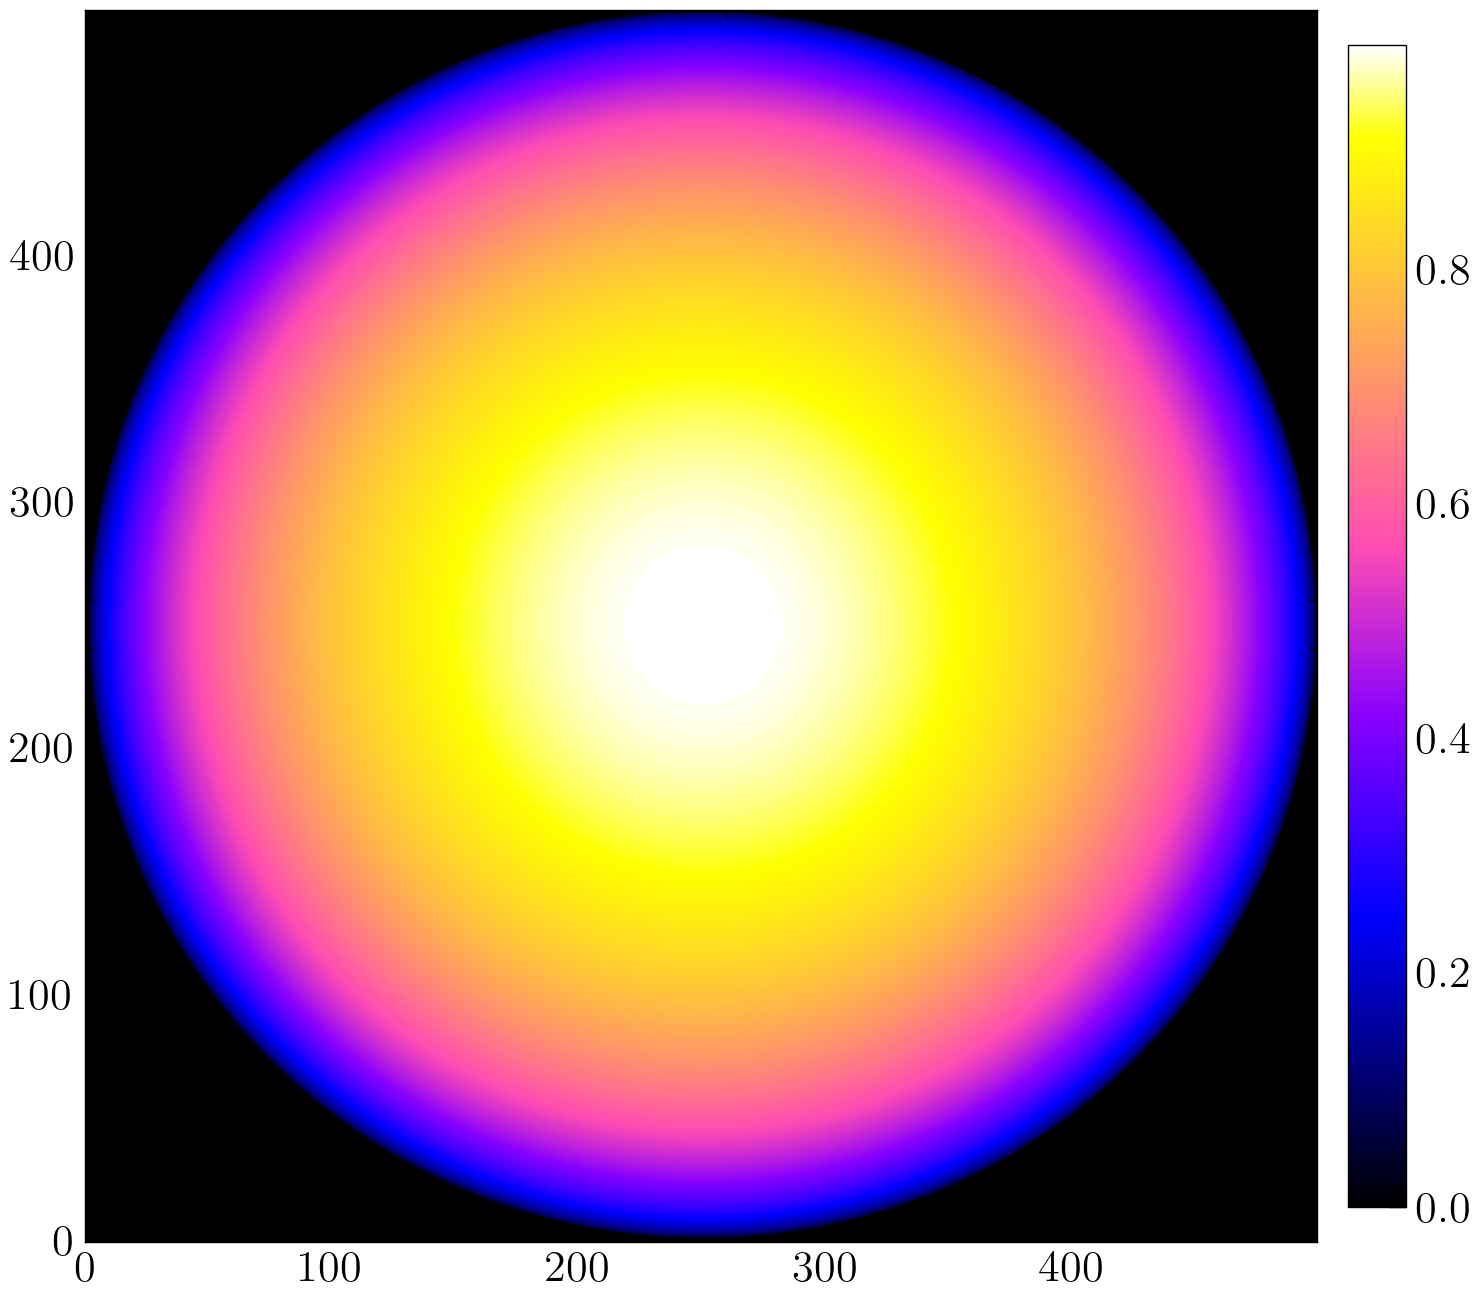

In [5]:
center = [side//2, side//2, side//2]
radius = side//2-1

sphere_2Dproj = Create_Sphere_2Dprojection(cube, center, radius)
cube = []

## Aperture photometry over concentrical annuli of equal area

In [6]:
def Find_Radii(image, center, radius, N_annuli):
    
    # Find an array of radii to have N_annuli concentric annuli of equal area
    radii = []
    radii.append(0)
    TotalArea = np.pi*(radius**2)
    Partition = TotalArea/N_annuli
    for i in range(N_annuli):
        radii.append(np.sqrt(Partition/np.pi + radii[i]**2))
        
    # Plot the annuli
    plt.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
    plt.colorbar(fraction=0.0375, pad=0.02)
    for i in range(N_annuli):
        circle = plt.Circle(center, radii[i], color='yellow', fill=False, linewidth=0.5)
        plt.gca().add_artist(circle)
    
    return np.array(radii)

In [7]:
# Function to cover the nebula with a circular mask
def Annulus_Flux(image, center, r1, r2):
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask_int = dist_from_center >= r1
    mask_ext = dist_from_center < r2
    mask_annulus = np.logical_and(mask_int, mask_ext)
    
    flux = np.sum(image[mask_annulus])
    
    return flux

array([  0.        ,  24.9       ,  35.2139177 ,  43.12806511,
        49.8       ,  55.67809264,  60.9922946 ,  65.87920765,
        70.42783541,  74.7       ,  78.74071374,  82.58395728,
        86.25613022,  89.77822676,  93.16726893,  96.43728532,
        99.6       , 102.66533008, 105.64175311, 108.53658369,
       111.35618528, 114.1061348 , 116.79135242, 119.41620493,
       121.98458919, 124.5       , 126.96558589, 129.38419533,
       131.75841529, 134.0906037 , 136.38291682, 138.63733263,
       140.85567081, 143.0396099 , 145.19070218, 147.3103866 ,
       149.4       , 151.460787  , 153.49390867, 155.50045016,
       157.48142748, 159.43779351, 161.37044339, 163.28021926,
       165.16791456, 167.03427792, 168.88001658, 170.70579955,
       172.51226043, 174.3       , 176.06958852, 177.82156787,
       179.55645352, 181.27473624, 182.97688379, 184.66334233,
       186.33453786, 187.99087744, 189.63275034, 191.26052912,
       192.87457064, 194.47521693, 196.06279606, 197.63

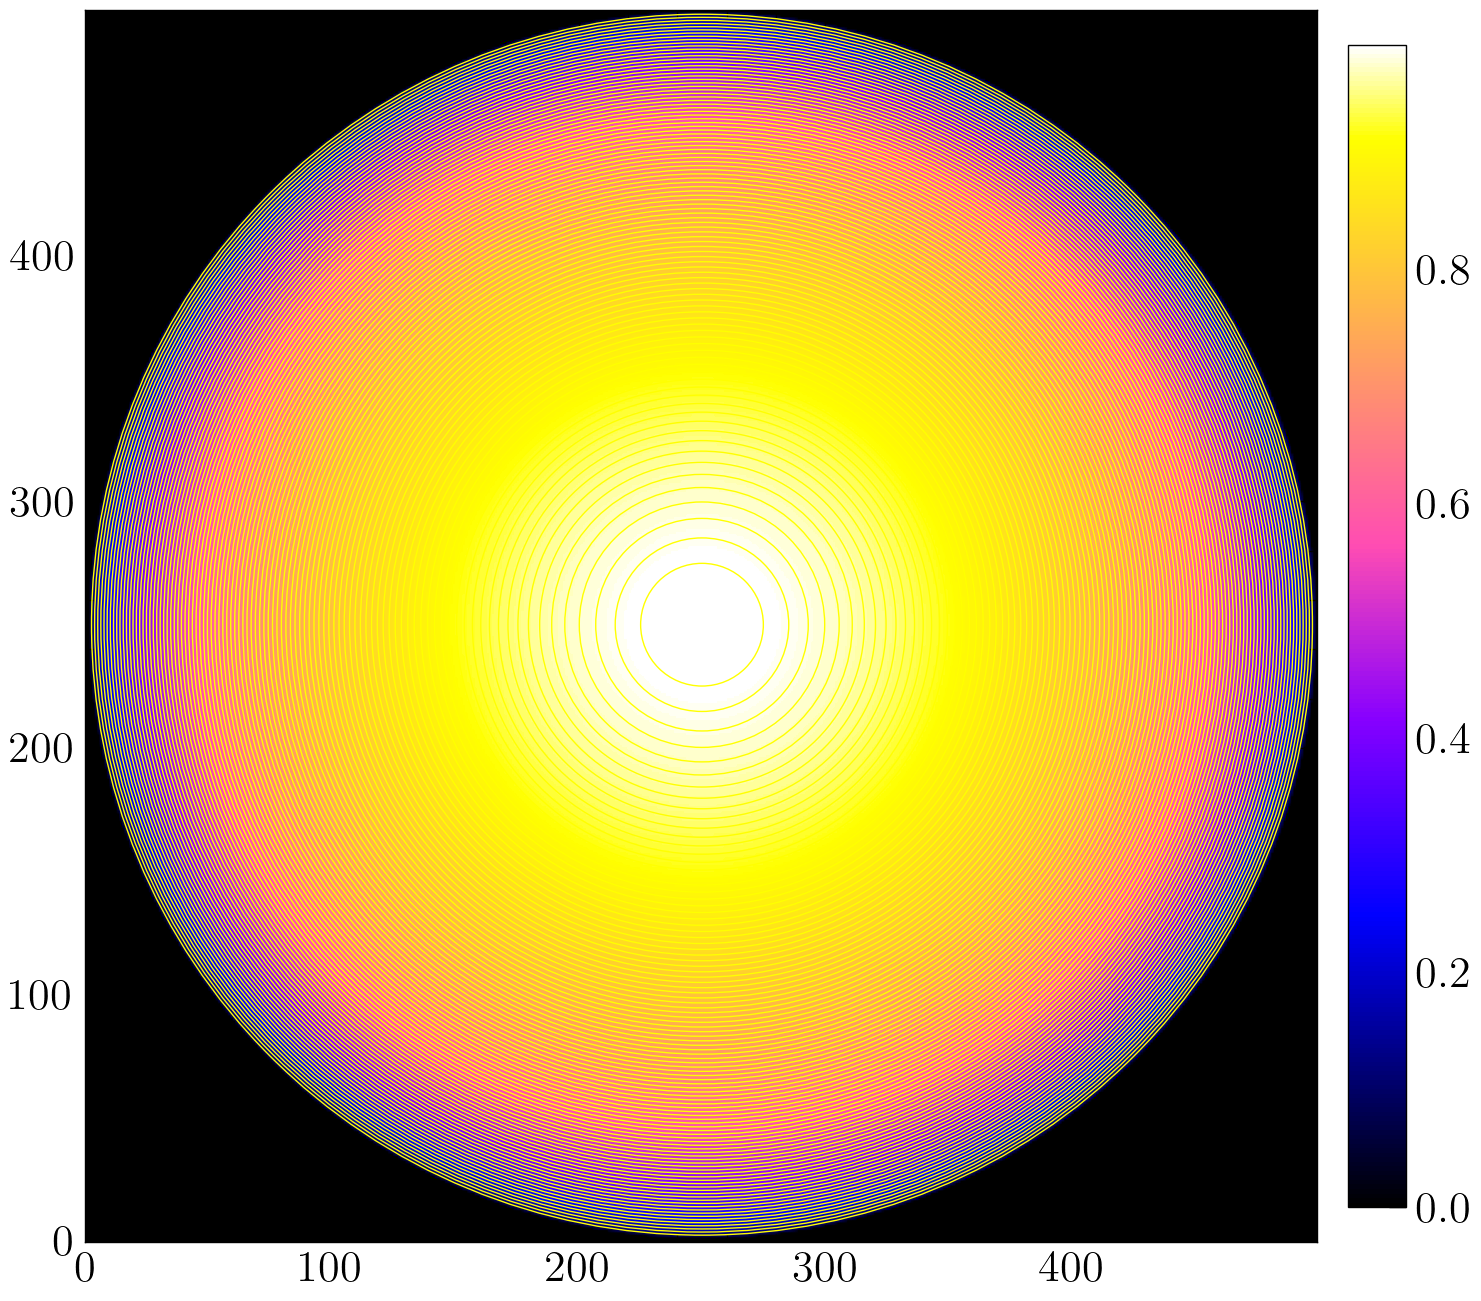

In [8]:
N_annuli = 100
 
radii = Find_Radii(sphere_2Dproj, center[:-1], radius, N_annuli)
radii

In [9]:
annuli_flux = []

for i in range(N_annuli):
    annulus_flux = Annulus_Flux(sphere_2Dproj, center[:-1], radii[i], radii[i+1])
    annuli_flux.append(annulus_flux)
    
annuli_flux = np.array(annuli_flux)

https://www.desmos.com/geometry/ywfmmi3btw?lang=it

Referring to the image at the link above:

* $s = 2R \cos(\alpha+\theta) \approx 2R \cos(\theta) \text{  for  } \alpha<<\theta$

* $I(\theta) = \int j ds = j s = 2jR \cos(\theta)$

* $L_\text{annulus} (\theta) = I(\theta) \times S_\text{annulus} \propto \cos(\theta)$

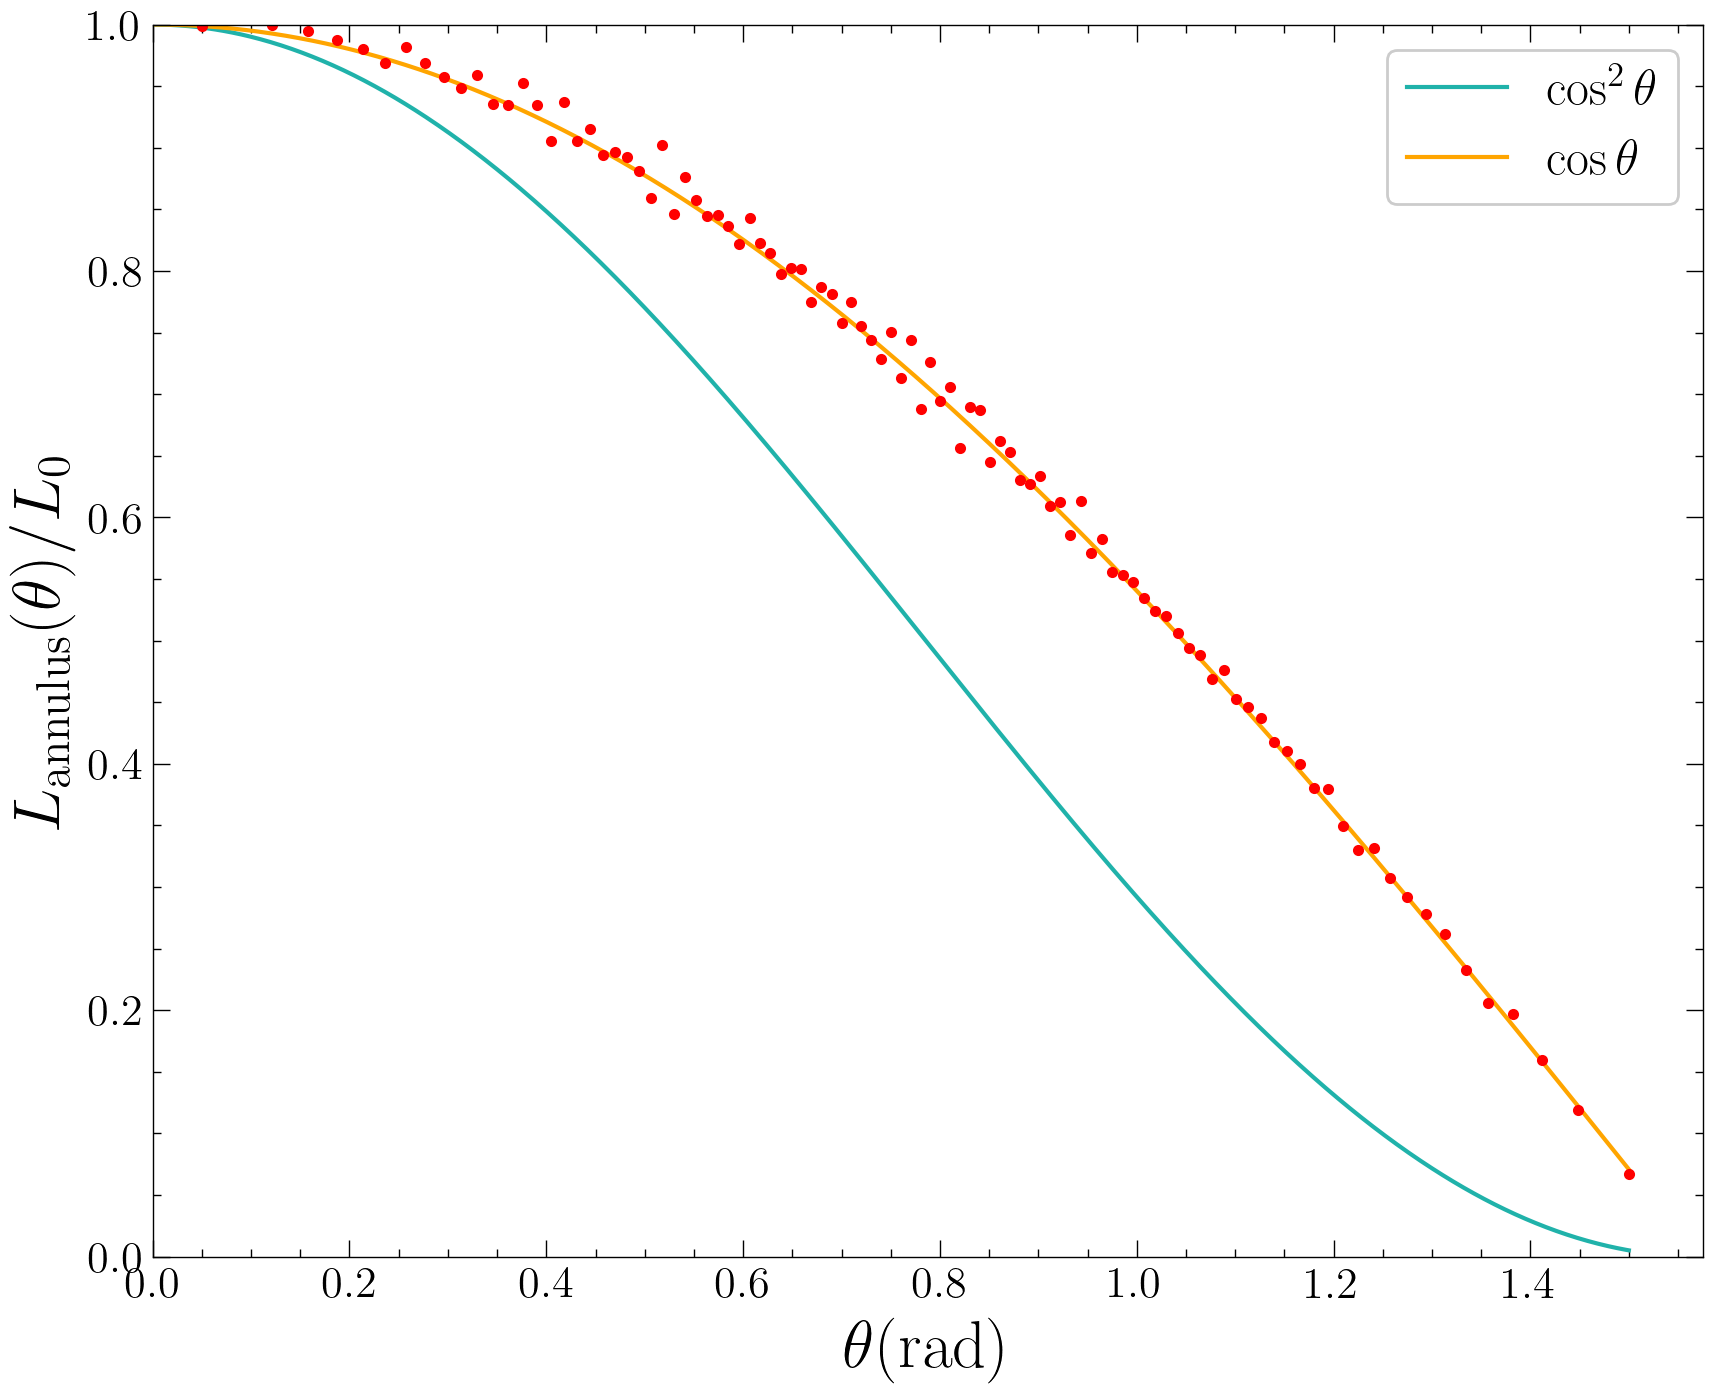

In [10]:
mean_radii = (radii[1:] + radii[:-1])/2
theta = np.arcsin(mean_radii/radius)
C_norm = 0.67/np.mean(annuli_flux)
plt.errorbar(theta, annuli_flux*C_norm, fmt='o', color='red', markersize=3)

theta_dense = np.linspace(0, np.max(theta), 1000)
plt.plot(theta_dense, np.cos(theta_dense)**2, color='lightseagreen', label='$\cos^2 \\theta$')
plt.plot(theta_dense, np.cos(theta_dense), color='orange', label='$\cos \\theta$')
plt.xlim(0)
plt.ylim(0, 1)
plt.xlabel('$\\theta (\\text{rad})$')
plt.ylabel('$L_\\text{annulus} (\\theta)/L_0$')
plt.legend();

## Case with emissivity $\propto r^{-2}$

In [11]:
def Create_Sphere_2Dprojection(image, center, radius, plot=True):
    X, Y, Z = np.ogrid[:image.shape[0], :image.shape[1], :image.shape[2]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2 + (Z-center[2])**2)

    image[dist_from_center > radius] = 0
    
    image[dist_from_center <= radius] = 1/(1+dist_from_center[dist_from_center <= radius])**2
    
    image_2d = image.sum(axis=2)/np.max(image.sum(axis=2))
    
    # Plot the results
    if plot==True:
        plt.imshow(image_2d, clim=(0, np.quantile(image_2d, [0.99])), cmap='gnuplot2', origin='lower')
        plt.colorbar(fraction=0.0375, pad=0.02);
    
    return image_2d

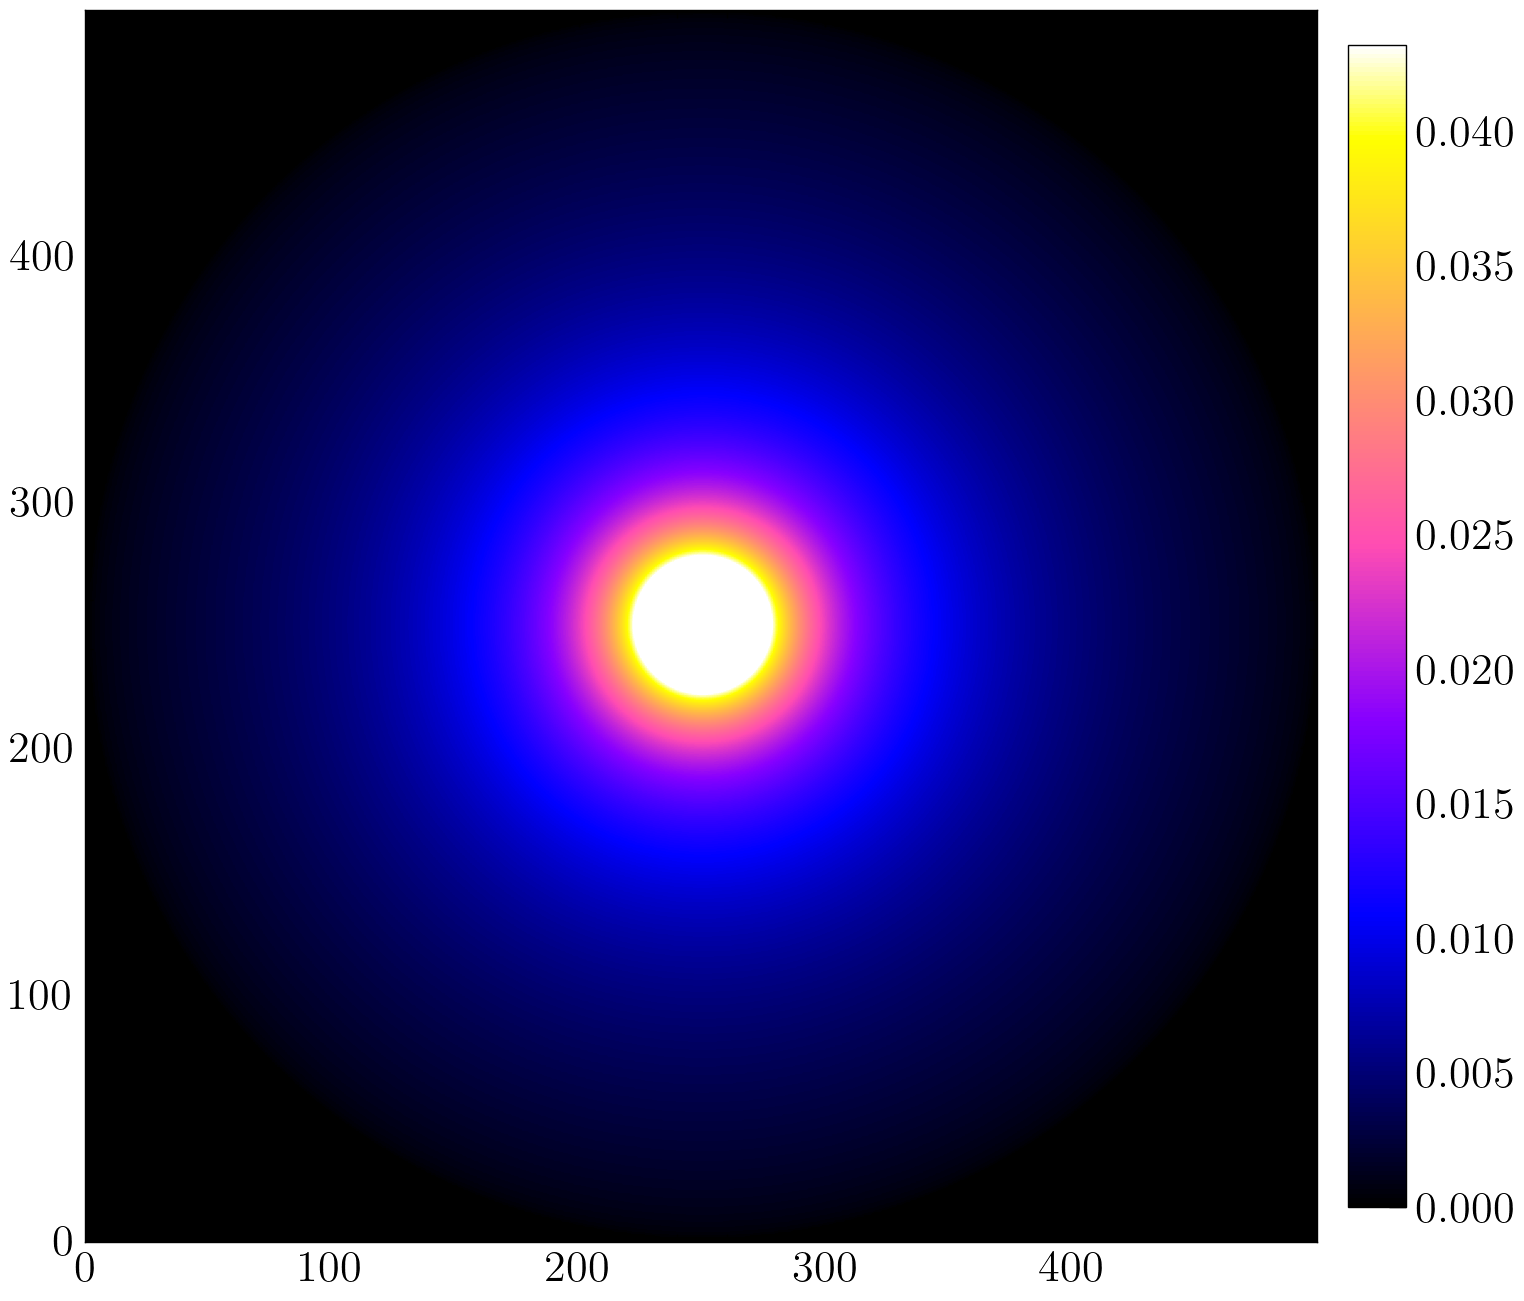

In [12]:
cube = np.ones((side, side, side))

sphere_2Dproj = Create_Sphere_2Dprojection(cube, center, radius)
cube = []

In [13]:
annuli_flux = []

for i in range(N_annuli):
    annulus_flux = Annulus_Flux(sphere_2Dproj, center[:-1], radii[i], radii[i+1])
    annuli_flux.append(annulus_flux)
    
annuli_flux = np.array(annuli_flux)

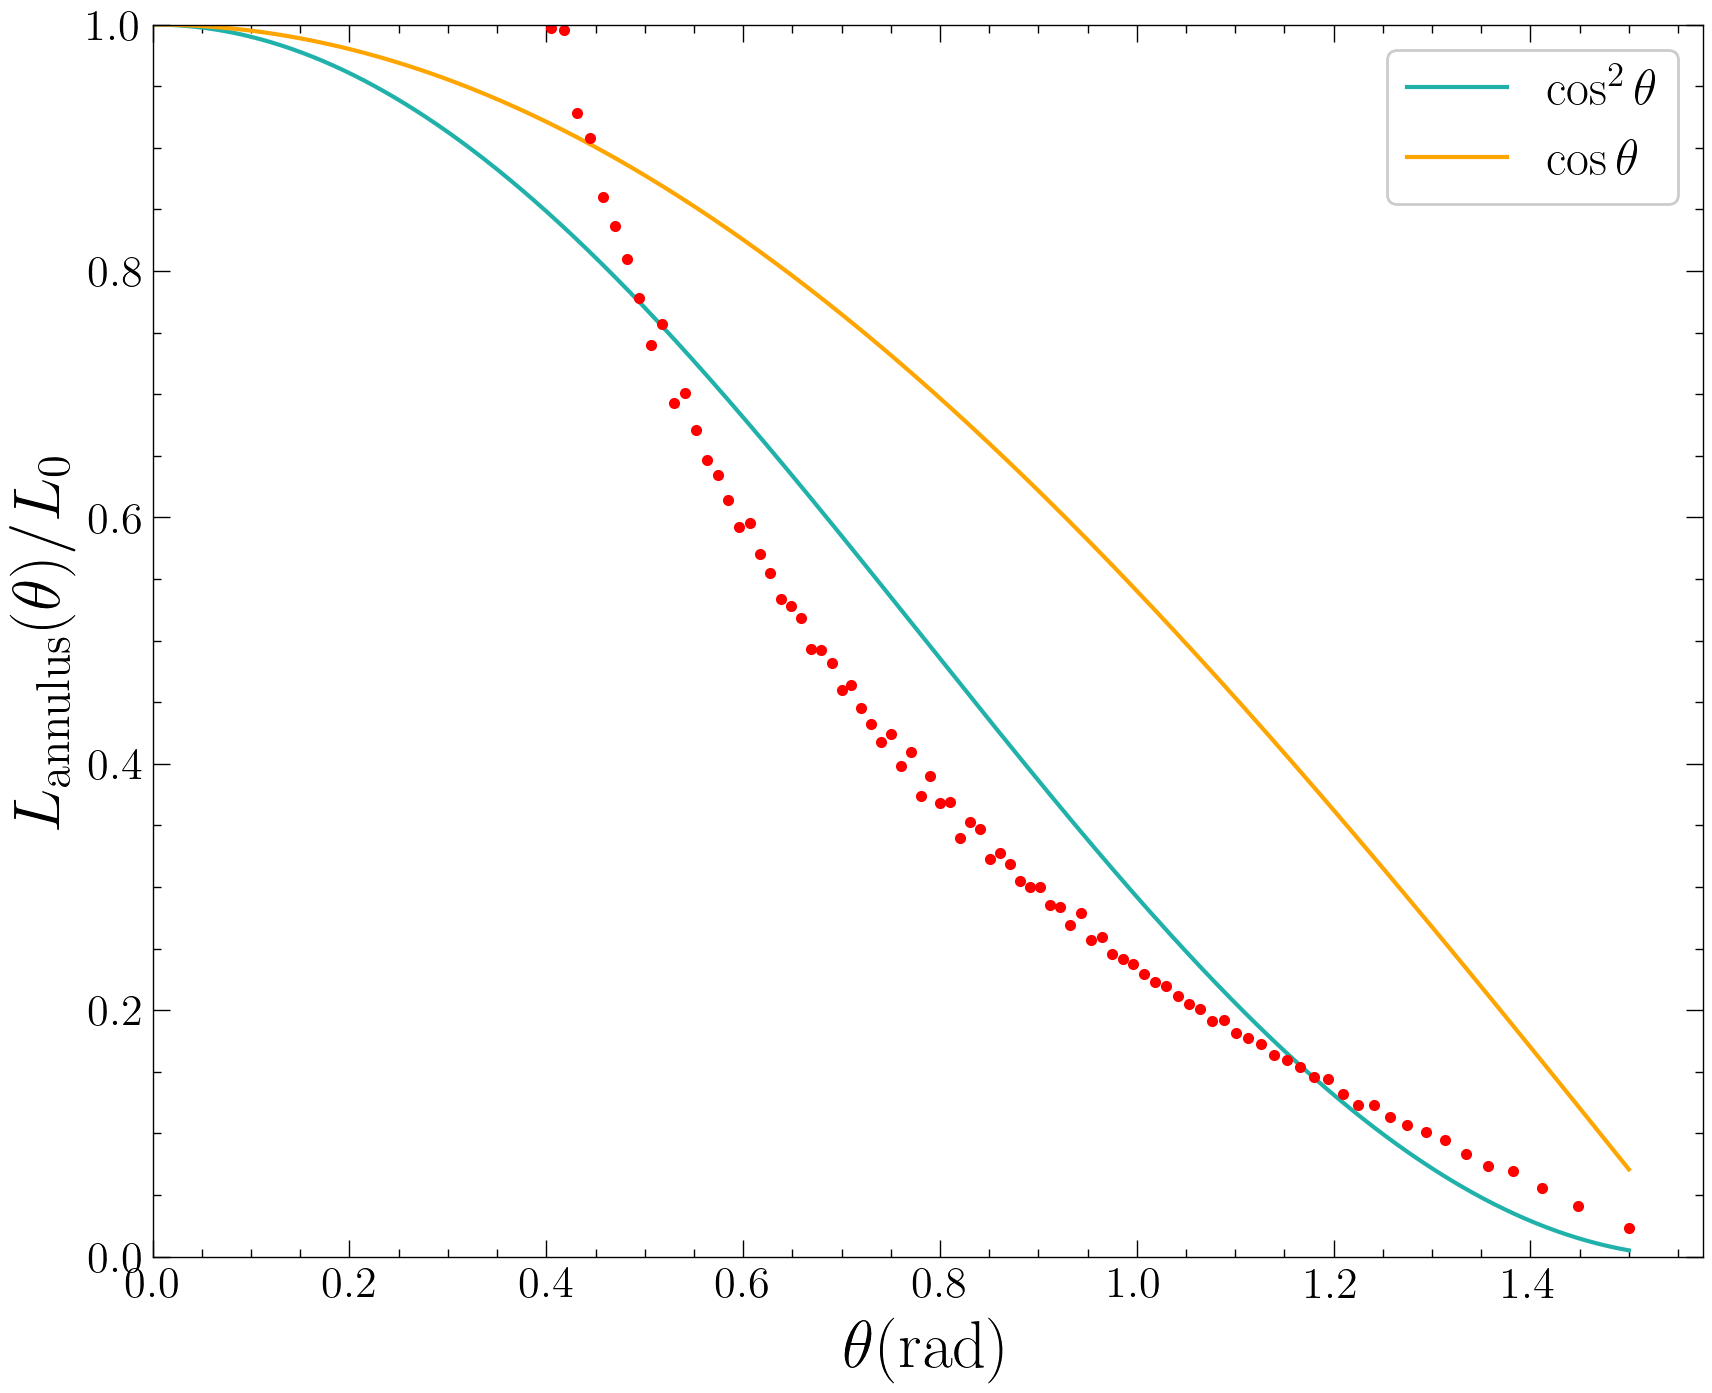

In [14]:
mean_radii = (radii[1:] + radii[:-1])/2
theta = np.arcsin(mean_radii/radius)
C_norm = 0.67/np.mean(annuli_flux)
plt.errorbar(theta, annuli_flux*C_norm, fmt='o', color='red', markersize=3)

theta_dense = np.linspace(0, np.max(theta), 1000)
plt.plot(theta_dense, np.cos(theta_dense)**2, color='lightseagreen', label='$\cos^2 \\theta$')
plt.plot(theta_dense, np.cos(theta_dense), color='orange', label='$\cos \\theta$')
plt.xlim(0)
plt.ylim(0, 1)
plt.xlabel('$\\theta (\\text{rad})$')
plt.ylabel('$L_\\text{annulus} (\\theta)/L_0$')
plt.legend();